# Key-Value Attention Mechanism Homework on Keras: Character-level Machine Translation (Many-to-Many, encoder-decoder)

In this homework, you will create an MT model with key-value attention mechnism that coverts names of constituency MP candidates in the 2019 Thai general election from Thai script to Roman(Latin) script. E.g. นิยม-->niyom 

In [1]:
%matplotlib inline
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Bidirectional, Concatenate, Permute, Dot, Input, LSTM, Multiply
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import load_model, Model
import keras.backend as K
import numpy as np
import tensorflow as tf

import random

Using TensorFlow backend.


## Load Dataset
We have generated a toy dataset using names of constituency MP candidates in 2019 Thai General Election from elect.in.th's github(https://github.com/codeforthailand/dataset-election-62-candidates) and tltk (https://pypi.org/project/tltk/) library to convert them into Roman script.

<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/dataset_diagram.png" alt="Drawing" style="width: 500px;"/>


In [2]:
import csv
with open('mp_name_th_en.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    name_th = []
    name_en = []
    for row in readCSV:
        name_th.append(row[0])
        name_en.append(row[1])

In [3]:
for th, en in zip(name_th[:10],name_en[:10]):
    print(th,en)

ไกรสีห์ kraisi
พัชรี phatri
ธีระ thira
วุฒิกร wutthikon
ไสว sawai
สัมภาษณ์  samphat
วศิน wasin
ทินวัฒน์ thinwat
ศักดินัย sakdinai
สุรศักดิ์ surasak


## Task1: Preprocess dataset for Keras (1 point)
* 2 dictionaries for indexing (1 for input and another for output)
* DON'T FORGET TO INCLUDE special token for padding
* DON'T FORGET TO INCLUDE special token for the end of word symbol (output)
* Be mindful of your pad_sequences "padding" hyperparameter. Choose wisely (post-padding vs pre-padding)

In [4]:
#FILL YOUR CODE HERE
input_dict = dict()
output_dict = dict()
input_dict['<PAD>'] = 0
output_dict['<PAD>'] = 0
#input_dict['</S>'] = 1
output_dict['</S>'] = 1

rev_input = dict()
rev_output = dict()

for word in name_th:
    for char in word:
        if char not in input_dict:
            input_dict[char] = len(input_dict)

for word in name_en:
    for char in word:
        if char not in output_dict:
            output_dict[char] = len(output_dict)

for char in input_dict:
    rev_input[input_dict[char]] = char
for char in output_dict:
    rev_output[output_dict[char]] = char
    
data_size, vocab_size = len(name_th), len(input_dict)+1 
output_vocab_size = len(output_dict)+1
input_word2char = []
output_word2char = []
for word in name_th:
    input_word2char.append([w for w in word])
for word in name_en:
    output_word2char.append([w for w in word]+['</S>'])
    
max_len = max([len(i) for i in input_word2char])
output_max_len = max([len(i) for i in output_word2char])

print('Data size:',data_size)
print('Vocab size:',vocab_size)
print('Max input lenght:',max_len,'\n')
print('Output vocab size:',output_vocab_size)
print('Max output lenght:',output_max_len,'\n')

X = []
for word in name_th:
    tmp = []
    for char in word:
        tmp.append(input_dict[char])
    X.append(tmp)
    
Y = []
for word in name_en:
    tmp = []
    for char in word:
        tmp.append(output_dict[char])
    tmp.append(output_dict['</S>'])
    Y.append(tmp)
X = pad_sequences(X,maxlen=max_len)
Y = pad_sequences(Y,maxlen=output_max_len)

print(Y[0],name_en[0])

X= to_categorical(X,vocab_size)
X=X.reshape(data_size,max_len ,vocab_size)

Y= to_categorical(Y,output_vocab_size)
Y=Y.reshape(data_size,output_max_len ,output_vocab_size)

print(Y[0][-8:])
print(rev_output)
print(X.shape,Y.shape)

m=data_size
Tx=max_len
Ty=output_max_len

Data size: 10887
Vocab size: 66
Max input lenght: 20 

Output vocab size: 25
Max output lenght: 20 

[0 0 0 0 0 0 0 0 0 0 0 0 0 2 3 4 5 6 5 1] kraisi
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]]
{0: '<PAD>', 1: '</S>', 2: 'k', 3: 'r', 4: 'a', 5: 'i', 6: 's', 7: 'p', 8: 'h', 9: 't', 10: 'w', 11: 'u', 12: 'o', 13: 'n', 14: 'm', 15: 'd', 16: 'e', 17: 'c', 18: 'l', 19: 'g', 20: 'y', 21: 'b', 22: 'f', 23: 

# Attention Mechanism
## Task 2: Code your own (key-value) attention mechnism (1 point)
* PLEASE READ: you DO NOT have to follow all the details in (Daniluk, et al. 2017). You just need to create a key-value attention mechanism where the "key" part of the mechanism is used for attention score calculation, and the "value" part of the mechanism is used to encode information to create a context vector.  
* Define global variables
* fill code for one_step_attention function
* Hint: use keras.layers.Lambda 
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo


In [5]:
from keras.activations import softmax
from keras.layers import Lambda
def softMaxAxis1(x):
    return softmax(x,axis=1)

In [6]:
#These are global variables (shared layers)
## Fill your code here
repeator = RepeatVector(Tx)
concatenator = Concatenate(axis=-1)
#Attention function###
fattn_1 = Dense(100, activation = "tanh")
fattn_2 = Dense(1, activation = "relu")
###
activator = Activation(softMaxAxis1, name='attention_scores') 
dotor = Dot(axes = 1)
## you are allowed to use code in the demo as your template.  

In [7]:
def one_step_attention(a, s_prev):

    #Fill code here
    # Repeat the decoder hidden state to concat with encoder hidden states
    #key, con = tf.split(a,2,1)
    key = Lambda(lambda x: x[:,:,:128])(a)
    con = Lambda(lambda x: x[:,:,128:])(a)
    s_prev = repeator(s_prev)
    concat = concatenator([s_prev,key])
    # attention function
    e = fattn_1(concat)
    energies =fattn_2(e)
    # calculate attention_scores (softmax)
    attention_scores = activator(energies)
    #calculate a context vector
    context = dotor([attention_scores,con])
    return context,attention_scores

## Task3: Create and train your encoder/decoder model here (1 point)
* HINT: you will probably need more hidden dimmensions than what you've seen in the demo

In [8]:
#FILL CODE HERE
n_h = 128 #hidden dimensions for encoder 
n_s = 128 #hidden dimensions for decoder
decoder_LSTM_cell = LSTM(n_s, return_state = True) #decoder_LSTM_cell
output_layer = Dense(output_vocab_size, activation="softmax") #softmax output layer
#att_layer = Dense(max_len, activation=None) #None output layer

In [9]:
#FIT YOUR MODEL HERE
def model(Tx, Ty, n_h, n_s, vocab_size, machine_vocab_size):
    """
    Arguments:
    Tx -- length of the input sequence
    Ty -- length of the output sequence
    n_h -- hidden state size of the Bi-LSTM
    n_s -- hidden state size of the post-attention LSTM
    vocab_size -- size of the input vocab
    output_vocab_size -- size of the output vocab

    Returns:
    model -- Keras model instance
    """
    
    # Define the input of your model
    X = Input(shape=(Tx, vocab_size))
    # Define hidden state and cell state for decoder_LSTM_Cell
    s0 = Input(shape=(n_s,), name='s0')
    c0 = Input(shape=(n_s,), name='c0')
    s = s0
    c = c0
    
    # Initialize empty list of outputs
    outputs = list()
    #Encoder Bi-LSTM
    h = Bidirectional(LSTM(n_h, return_sequences=True),input_shape=(m, Tx, n_h*2))(X)
  
    #Iterate for Ty steps (Decoding)
    for t in range(Ty):
    
        #Perform one step of the attention mechanism to calculate the context vector at timestep t
        context,attention = one_step_attention(h, s)
       
        # Feed the context vector to the decoder LSTM cell
        s, _, c = decoder_LSTM_cell(context,initial_state=[s,c])
        
        # Pass the decoder hidden output to the output layer (softmax)
        out = output_layer(s)

        # Append an output list with the current output
        outputs.append(out)

    #Create model instance
    model = Model(inputs=[X,s0,c0],outputs=outputs)
    
    return model

In [10]:
model = model(Tx, Ty, n_h, n_s, vocab_size, output_vocab_size)

In [11]:
opt = Adam(lr= 0.01, decay = 0.01)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 20, 66)       0                                            
__________________________________________________________________________________________________
s0 (InputLayer)                 (None, 128)          0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 20, 256)      199680      input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 128)      0           s0[0][0]                         
                                                                 lstm_1[0][0]                     
          

In [12]:
s0 = np.zeros((m, n_s))
c0 = np.zeros((m, n_s))
outputs = list(Y.swapaxes(0,1))

In [13]:
model.fit([X, s0, c0], outputs, epochs=40, batch_size=120)

Epoch 1/40
10887/10887 [==============================] - 33s 3ms/step - loss: 31.4717 - dense_3_loss: 2.4720 - dense_3_acc: 0.9887 - dense_3_acc_1: 0.9886 - dense_3_acc_2: 0.9879 - dense_3_acc_3: 0.9870 - dense_3_acc_4: 0.9856 - dense_3_acc_5: 0.9813 - dense_3_acc_6: 0.9732 - dense_3_acc_7: 0.9557 - dense_3_acc_8: 0.9240 - dense_3_acc_9: 0.8573 - dense_3_acc_10: 0.7514 - dense_3_acc_11: 0.5974 - dense_3_acc_12: 0.3860 - dense_3_acc_13: 0.2108 - dense_3_acc_14: 0.0969 - dense_3_acc_15: 0.0648 - dense_3_acc_16: 0.0161 - dense_3_acc_17: 0.0749 - dense_3_acc_18: 0.0280 - dense_3_acc_19: 0.1533
Epoch 2/40
10887/10887 [==============================] - 16s 1ms/step - loss: 21.9795 - dense_3_loss: 0.7425 - dense_3_acc: 0.9998 - dense_3_acc_1: 0.9997 - dense_3_acc_2: 0.9990 - dense_3_acc_3: 0.9981 - dense_3_acc_4: 0.9967 - dense_3_acc_5: 0.9924 - dense_3_acc_6: 0.9843 - dense_3_acc_7: 0.9664 - dense_3_acc_8: 0.9348 - dense_3_acc_9: 0.8692 - dense_3_acc_10: 0.7653 - dense_3_acc_11: 0.6214 - de

10887/10887 [==============================] - 15s 1ms/step - loss: 9.8048 - dense_3_loss: 0.0144 - dense_3_acc: 0.9998 - dense_3_acc_1: 0.9997 - dense_3_acc_2: 0.9990 - dense_3_acc_3: 0.9982 - dense_3_acc_4: 0.9966 - dense_3_acc_5: 0.9931 - dense_3_acc_6: 0.9851 - dense_3_acc_7: 0.9702 - dense_3_acc_8: 0.9421 - dense_3_acc_9: 0.8872 - dense_3_acc_10: 0.8189 - dense_3_acc_11: 0.7064 - dense_3_acc_12: 0.6007 - dense_3_acc_13: 0.5147 - dense_3_acc_14: 0.4844 - dense_3_acc_15: 0.6114 - dense_3_acc_16: 0.7272 - dense_3_acc_17: 0.8718 - dense_3_acc_18: 0.9133 - dense_3_acc_19: 0.9990
Epoch 15/40
10887/10887 [==============================] - 15s 1ms/step - loss: 9.2270 - dense_3_loss: 0.0119 - dense_3_acc: 0.9998 - dense_3_acc_1: 0.9997 - dense_3_acc_2: 0.9990 - dense_3_acc_3: 0.9981 - dense_3_acc_4: 0.9966 - dense_3_acc_5: 0.9930 - dense_3_acc_6: 0.9855 - dense_3_acc_7: 0.9712 - dense_3_acc_8: 0.9450 - dense_3_acc_9: 0.8928 - dense_3_acc_10: 0.8235 - dense_3_acc_11: 0.7235 - dense_3_acc_12

10887/10887 [==============================] - 15s 1ms/step - loss: 6.0275 - dense_3_loss: 0.0065 - dense_3_acc: 0.9998 - dense_3_acc_1: 0.9997 - dense_3_acc_2: 0.9990 - dense_3_acc_3: 0.9983 - dense_3_acc_4: 0.9970 - dense_3_acc_5: 0.9935 - dense_3_acc_6: 0.9879 - dense_3_acc_7: 0.9785 - dense_3_acc_8: 0.9604 - dense_3_acc_9: 0.9246 - dense_3_acc_10: 0.8743 - dense_3_acc_11: 0.8090 - dense_3_acc_12: 0.7424 - dense_3_acc_13: 0.7011 - dense_3_acc_14: 0.7163 - dense_3_acc_15: 0.7945 - dense_3_acc_16: 0.8753 - dense_3_acc_17: 0.9444 - dense_3_acc_18: 0.9584 - dense_3_acc_19: 0.9996
Epoch 28/40
10887/10887 [==============================] - 15s 1ms/step - loss: 5.8461 - dense_3_loss: 0.0065 - dense_3_acc: 0.9998 - dense_3_acc_1: 0.9997 - dense_3_acc_2: 0.9990 - dense_3_acc_3: 0.9983 - dense_3_acc_4: 0.9972 - dense_3_acc_5: 0.9937 - dense_3_acc_6: 0.9875 - dense_3_acc_7: 0.9780 - dense_3_acc_8: 0.9612 - dense_3_acc_9: 0.9288 - dense_3_acc_10: 0.8803 - dense_3_acc_11: 0.8177 - dense_3_acc_12

10887/10887 [==============================] - 15s 1ms/step - loss: 4.4843 - dense_3_loss: 0.0042 - dense_3_acc: 0.9998 - dense_3_acc_1: 0.9997 - dense_3_acc_2: 0.9990 - dense_3_acc_3: 0.9983 - dense_3_acc_4: 0.9975 - dense_3_acc_5: 0.9949 - dense_3_acc_6: 0.9902 - dense_3_acc_7: 0.9821 - dense_3_acc_8: 0.9674 - dense_3_acc_9: 0.9454 - dense_3_acc_10: 0.9082 - dense_3_acc_11: 0.8585 - dense_3_acc_12: 0.8010 - dense_3_acc_13: 0.7778 - dense_3_acc_14: 0.7978 - dense_3_acc_15: 0.8541 - dense_3_acc_16: 0.9194 - dense_3_acc_17: 0.9672 - dense_3_acc_18: 0.9737 - dense_3_acc_19: 0.9998


# Thai-Script to Roman-Script Translation
* Task 4: Test your model on 5 examples of your choice including your name! (1 point)
* Task 5: Show your visualization of attention scores on one of your example (1 point)

In [14]:
#task 4
#fill your code here
test = ["ภาคิน","ดีศรี","พิสิษฐ์","วจนสาระ","ปวินท์","เปี่ยมไทย","นิธิวุฒิ","วิไลนุช","ชวิศ","สกุลยืนยง"]
def prep_input(input_list):
    X = []
    for line in input_list:
        temp=[]
        for char in line:
            temp.append(input_dict[char])
        X.append(temp)
    X = pad_sequences(X,maxlen=max_len)
    x_padding = X
    X= to_categorical(X,vocab_size)
    X=X.reshape(len(input_list),max_len ,vocab_size)
    
    return X,x_padding
EXAMPLES,x_padding = prep_input(test)
print(EXAMPLES.shape)
prediction = model.predict([EXAMPLES, s0, c0])

(10, 20, 66)


In [15]:
prediction = np.swapaxes(prediction,0,1)
y_pred = prediction
prediction = np.argmax(prediction, axis = -1)
for j in range(len(prediction)):
    output = "".join([rev_output[int(i)] if int(i)>1  else '' for i in prediction[j]])
    print(j,output)

0 phakhin
1 iiri
2 phisit
3 wataansara
4 pawin
5 iimathai
6 ittwwwtthi
7 wiraanut
8 chawit
9 uuuudanyuang


### Plot the attention map
* If you need to install thai font: sudo apt install xfonts-thai
* this is what your visualization might look like:
<img src="https://raw.githubusercontent.com/ekapolc/nlp_2019/master/HW8/images/attn_viz_sample.png"  style="width: 350px;"/>

In [16]:
#task 5
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family']='Loma' #you can change to other font that works for you
#fill your code here
sns.set()

In [17]:
def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

att_layer = get_output_layer(model, "attention_scores")

In [18]:
s0 = np.zeros((len(test), n_s))
c0 = np.zeros((len(test), n_s))
s0.shape, c0.shape

((10, 128), (10, 128))

In [19]:
from keras import backend as K
percent = []
for i in range(output_max_len):
    output_fn = K.function(model.inputs, [att_layer.get_output_at(i)])
    percent.append(output_fn([EXAMPLES, s0, c0]))
percent = np.array(percent)
percent.shape

(20, 1, 10, 20, 1)

In [20]:
tmp = percent[0]
for i in percent[1:]:
    tmp = np.concatenate((tmp,i),axis = -1)
tmp = np.array(tmp)
tmp.shape

(1, 10, 20, 20)

20 20


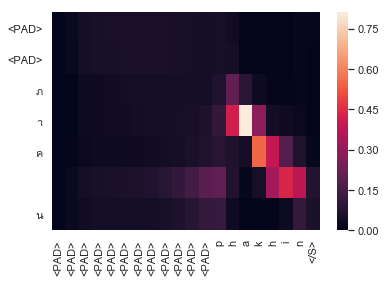

In [21]:
import pandas as pd
inp = [rev_input[int(i)] for i in x_padding[0]]
out = [rev_output[int(i)] for i in prediction[0]]
print(len(inp),len(out))
df = pd.DataFrame(tmp[0][0],index = inp, columns = out)
plt.rcParams['font.family']='Loma'
ax = sns.heatmap(df[-7:])